## Lecture 11 - Queueing theory

Queues are readily described and relate to our daily experiences regarding shopping, checking in at the airport, and waiting for service on the phone, etc. However, queues are quite elobarate from a theoretical point of view and even the simplest models require significant portion of the apparatus we have been developing in the course. They can be quite difficult to study, but fortunately, we can simulate them using Monte Carlo methods. 

The basic model is as follows:

Customers arrive at a service point or counter at which a number of servers are stationed. An arriving customer may need to wait until one of the servers becomes available. The customer then migrates to the head of the queue and is served by the next available server. We need to specify a number of details about this queueing system before we can model it:

(a) In what manner do customers enter the system?

(b) In what order are they served?

(c) How long are their service times?

Our main assumptions:

(a) We will assume that the arrivals will be a process $N(t)$ with iid interarrival times (like the Poisson process) - called a renewal process.

(b) Arriving customers join at the end of a single line of people and are served on a first come, first served basis

(c) Services times are iid random variables.


The state of the queue at time $t$ is described by the number $Q(t)$, representing the number of waiting customers, including customers that are being served.

If we assume that the service time is $S$ and the interarrival time of the customers is $X$, then we define the **traffic intensity** as

$$\rho = \frac{E[S]}{E[X]}$$

You can imagine if we have a high traffic intensity - that means that the service time is high compared to the interarrival times, and the queue will just get longer and longer ($Q(t)$ will just grow). However, if the traffic intensity is low, then the service time is fast compared to interarrival times and the queue will not be long. If the traffic intensity is 1, then the mean service time is the same as the mean interarrival time. One might think that this is ok, but since there are always variations in both variables, the queue will build up. This is actually a theorem:

If the queue $\{Q(t), t \ge o\}$ has a single server and traffic intensity $\rho$, then

(a) If $\rho < 1$ then $Q(t)$ is stable

(b) If $\rho > 1$ then $Q(t)$ is unstable

(c) If $\rho = 1$ then $Q(t)$ is unstable if $S$ or $X$ have any variance

It is most common to describe a queing system with a triplet A/B/s, where A describes the interarrival times, B describes the service times, and s is the number of servers.

The letter $M$ refers to exponential interarrival or waiting times with parameter $\lambda$, i.e., the number of arrivals is a Poisson process.

### L11.1 M/M/1

This is a queue with exponential interarrival times with parameter $\lambda$ and exponential service times with parameter $\mu$. The task is to find the distribution of $Q(t)$, i.e., the distribution of the number of people (or things) in the queue at time $t$ (which means, find $P(Q(t)=n)$ for all $n$).

* Arrivals occur at rate $\lambda$, so the mean arrival time 1/$\lambda$
* Service is done at a rate of $\mu$, so the mean service time is 1/$\mu$
* The traffic rate is thus $\frac{\lambda}{\mu}$

The theorem then says that if $\rho < 1$, i.e., if on average the service time is shorter than the arrival time, then we are good. However, if the service time is the same or higher than the arrival times (on average), then the queue will explode - more and more people will be waiting.

Let's apply a simulation to see what happens. Don´t worry about the details, but let´s look at the overall algorithm.

[2, 3, 5]


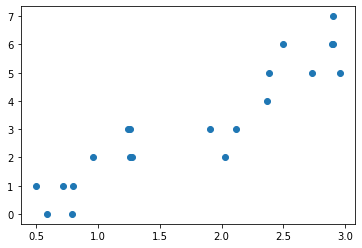

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Params
lambda_ = 5 #5 per time unit on average arrive
mu_ = 10 #10 people served per time unit on average
N = 3 #Time units simulated

#np.random.seed(42)


def gen_interarrival_times(N,lambda_):
    #Create interarrival times for up to N units with rate lambda_
    result = []
    time_ = 0

    while time_ < N:
        interarrival = np.random.exponential(1/lambda_)
        time_ += interarrival
        if time_ < N:
            result.append(time_)
    return result
    
def generate_MM1queue(N, lambda_,mu_):
    #Return a dataframe showing one realization of MM1 queue
    #for N time periods
    inter_arrivals = gen_interarrival_times(N,lambda_)

    #Time starts at zero, and then the first customer arrives
    time_ = inter_arrivals[0]
    #create counters for arrived and served customers
    arrived_customers = 1
    served_customers = 0 #Customers that have started to be served
    departed_customers = 0

    #Keep track of arrivals and departures, etc. in a dataframe
    ts_columns = ['time', 'type', 'queue', 'arr cust',
                  'served cust', 'depar cust']
    time_series =  pd.DataFrame([[inter_arrivals[0], "arrival", 
                                  1, 1, 0, 0]], columns = ts_columns) 

    next_arrival = 1 #Index into the inter_arrivals array
    queue = 1 #One person in the queue
    while time_ < N:
        #Check how long it takes to serve the customer
        #and account for all events that happen until the service is completed

        #If the queue is empty, then need to advance it, i.e., add the next arrival
        if queue == 0:
            if next_arrival < len(inter_arrivals):
                time_ = inter_arrivals[next_arrival]
                arrived_customers += 1
                next_arrival += 1
                queue = 1
                generated_events =  pd.DataFrame(
                                [[time_ , "arrival", 
                              1,arrived_customers, 
                                 served_customers,
                                 departed_customers]], columns = ts_columns) 


                time_series =  pd.concat([time_series, generated_events])
            else:
                break #No more arrivals and nothing to do

        #Now, the queue is not empty, and someone is served
        #So simulate the service time
        servicetime = np.random.exponential(1/mu_)

        if next_arrival >= len(inter_arrivals):
            #No more arrival, just check to see if the service happens before close
            if time_ + servicetime <= N:
                departed = 1 #Service completed before close
            else:
                departed = 0 #Service notcompleted before close
            generated_events =  pd.DataFrame(
                                [[time_ + servicetime, "departure", 
                              queue-1,arrived_customers, 
                                 served_customers+1,
                                 departed_customers+departed]], columns = ts_columns) 


            time_series =  pd.concat([time_series, generated_events])
            break
        elif time_ + servicetime > N:
            #Cannot service this customer before close
            #Add the remaining arrivals and close
            times = inter_arrivals[next_arrival:]
            queues = queue + np.cumsum(np.ones(len(times)))
            arr_cust = arrived_customers + np.cumsum(np.ones(len(times)))
            generated_events =  pd.DataFrame(
                                    {'time':times,
                                     'type':len(times)*['arrival'],
                                      'queue':queues,
                                      'arr cust': arr_cust,
                                      'served cust':len(times)*[served_customers+1],
                                       'depar cust':len(times)*[departed_customers]
                                      }) 


            time_series =  pd.concat([time_series, generated_events])
            break
        elif time_ + servicetime >= inter_arrivals[next_arrival]:
            #People will arrive before the service is finished,
            #add them to the queue
            new_arrivals = []
            new_times = []
            new_queue = []
            while (next_arrival < len(inter_arrivals)) and (inter_arrivals[next_arrival] < time_ + servicetime):
                arrived_customers += 1
                queue += 1
                new_times.append(inter_arrivals[next_arrival])
                new_arrivals.append(arrived_customers)
                new_queue.append(queue)
                next_arrival += 1
            generated_events =  pd.DataFrame(
                                    {'time':new_times,
                                     'type':len(new_times)*['arrival'],
                                      'queue':new_queue,
                                      'arr cust': new_arrivals,
                                      'served cust':len(new_times)*[served_customers],
                                       'depar cust':len(new_times)*[departed_customers]
                                      }) 
            time_series =  pd.concat([time_series, generated_events])

        #Can service the person before the next one arrives
        time_ += servicetime
        served_customers += 1
        departed_customers += 1
        queue -= 1
        generated_events =  pd.DataFrame(
                                [[time_ , "departure", 
                              queue,arrived_customers, 
                                 served_customers,
                                 departed_customers]], columns = ts_columns) 


        time_series =  pd.concat([time_series, generated_events])
    return time_series
    
    
def collectQ(mm1,N):
    #Return Q(t) for t = 1, 2, 3, .., N
    ind = 0 #Index into the Q
    Q = [] #Values at 1, 2, ..., N
    for i in range(1,N+1):
        if ind >= len(mm1):
            Q.append(mm1.iloc[ind-1]["queue"])
            continue
        if mm1.iloc[ind]["time"] < i:
            while ind < len(mm1) and mm1.iloc[ind]["time"] <= i:
                ind += 1
            #Now, the time is over i, so pick the previous time
            Q.append(mm1.iloc[ind-1]["queue"])
        else:
            Q.append(mm1.iloc[ind]["queue"]) #Already over and nothing before
    return Q


mm1 = generate_MM1queue(N, lambda_,2)
plt.plot(mm1["time"],mm1["queue"],'o',label="Q(t)")
print(collectQ(mm1,N))

The M/M/1 queue is a rare example of a queue that can be analyzed in detail using theory. One can in fact derive the following theorem using (continuous time) Markov Chains:

Let $\rho = \lambda/\mu$ be the traffic intensity. Then,

(1) If $\rho < 1$, then $P(Q(t) = n) \rightarrow (1-\rho)\rho^n$ as $t \rightarrow \infty$

(2) If $\rho \ge 1$, then there is no limiting distribution and $P(Q(t) = n) \rightarrow 0$ for all $n$.

The first part means that the queue wil settle down into an equilibrium distribution if the service times are shorter than the arrival times on average. The second part means that as time moves on, the probability of any finite number of people in queue gets smaller and smaller, i.e., the queue explodes.

0 10 [0.463, 0.26, 0.123, 0.078, 0.047, 0.013, 0.005, 0.008, 0.001, 0.001, 0.001]


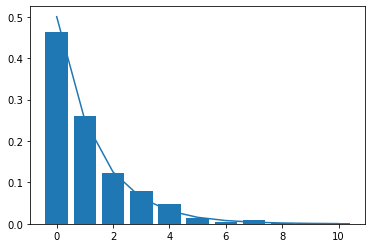

In [5]:
#Now, simulate many queues and see if we recover the distribution

M = 1000
lambda_ = 5 #5 per time unit on average arrive
mu_ = 10 #10 people served per time unit on average
rho = lambda_/mu_ #Traffic intensity

N = 3

Qsamples = [[] for i in range(N)] #A list of lists, Qdist[i] = [samples of Q at time i+1]

for i in range(M):
    mm1 = generate_MM1queue(N, lambda_,mu_)
    Q = collectQ(mm1,N)
    for k,q in enumerate(Q):
        Qsamples[k].append(q)


t = 2 #Look at time 3 (index is 2)
Q_t_samples = np.array(Qsamples[t])
min_ = int(min(Q_t_samples))
max_ = int(max(Q_t_samples))
Qdist = [len(Q_t_samples[Q_t_samples==k])/M for k in range(min_,max_+1)] #Aggregate the values

print(min_,max_,Qdist)
plt.bar(range(min_,max_+1),Qdist) 

#Compare with theoretical, limiting distribution
limiting_dist = [(1-rho)*rho**n for n in range(min_,max_+1)]
plt.plot(range(min_,max_+1),limiting_dist)

### L11.2 M/G/1

Another common queue-ing model is the M/G/1 model. This means that we have exponential arrival times as before, but we have a general service time model (just some distribution for the service times). This model is signifcantly more difficult to analyze from a theoretical point of view. The main theorem above still works for the M/G/1 (when the traffic intensity is less than 1, the queue is stable), but the limiting distribution is not explicit.

One example is M/$\Gamma$/1, where the service time is a gamma distribution (https://en.wikipedia.org/wiki/Gamma_distribution), which has a pdf

$$f(x) = \frac{1}{\Gamma(t)}\lambda^tx^{t-1}e^{-\lambda x}$$

where $\Gamma (t)$ is the gamma function

$$\Gamma (t) = \int_0^{\infty}{x^{t-1}e^x dx} $$

The mean of the gamma distribution is $\frac{t}{\lambda}$

We can simulate M/G/1 in exactly the same way as before, just change the random generation of the service time. We can play with the parameters and see whether the queue builds up, or whether the queue remains stable.

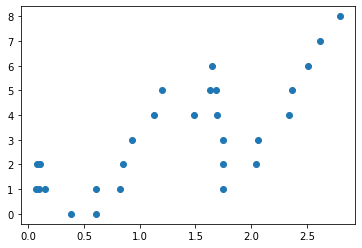

In [72]:
#Params
lambda_ = 5 #5 per time unit on average arrive
lambda_gamma = 1 
t = 0.2 ##5 people served per time unit on average, t/lambda_gamma
N = 3 #Time units simulated

#np.random.seed(42)
    
def generate_MGamma1queue(N, lambda_,lambda_gamma, t):
    #Return a dataframe showing one realization of MM1 queue
    #for N time periods
    inter_arrivals = gen_interarrival_times(N,lambda_)

    #Time starts at zero, and then the first customer arrives
    time_ = inter_arrivals[0]
    #create counters for arrived and served customers
    arrived_customers = 1
    served_customers = 0
    departed_customers = 0

    #Keep track of arrivals and departures, etc. in a dataframe
    ts_columns = ['time', 'type', 
                  'queue', 'arr cust', 'served cust', 'depar cust']
    time_series =  pd.DataFrame([[inter_arrivals[0], "arrival", 
                                  1, 1, 0, 0]], columns = ts_columns) 

    next_arrival = 1 #Index into the inter_arrivals array
    queue = 1 #One person in the queue
    while time_ < N:
        #Check how long it takes to serve the customer
        #and account for all events that happen until the service is completed

        #If the queue is empty, then need to advance it
        if queue == 0:
            if next_arrival < len(inter_arrivals):
                time_ = inter_arrivals[next_arrival]
                arrived_customers += 1
                next_arrival += 1
                queue = 1
                generated_events =  pd.DataFrame(
                                [[time_ , "arrival", 
                              1,arrived_customers, 
                                 served_customers,
                                 departed_customers]], columns = ts_columns) 


                time_series =  pd.concat([time_series, generated_events])
            else:
                break #No more arrivals and nothing to do

        #Now, the queue is not empty, and someone is served
        #So simulate the service time
        servicetime = np.random.gamma(t,1/lambda_gamma)

        if next_arrival >= len(inter_arrivals):
            #No more arrival, just check to see if the service happens before close
            if time_ + servicetime <= N:
                departed = 1 #Service completed before close
            else:
                departed = 0 #Service notcompleted before close
            generated_events =  pd.DataFrame(
                                [[time_ + servicetime, "departure", 
                              queue-1,arrived_customers, 
                                 served_customers+1,
                                 departed_customers+departed]], columns = ts_columns) 


            time_series =  pd.concat([time_series, generated_events])
            break
        elif time_ + servicetime > N:
            #Cannot service this customer before close
            #Add the remaining arrivals and close
            times = inter_arrivals[next_arrival:]
            queues = queue + np.cumsum(np.ones(len(times)))
            arr_cust = arrived_customers + np.cumsum(np.ones(len(times)))
            generated_events =  pd.DataFrame(
                                    {'time':times,
                                     'type':len(times)*['arrival'],
                                      'queue':queues,
                                      'arr cust': arr_cust,
                                      'served cust':len(times)*[served_customers+1],
                                       'depar cust':len(times)*[departed_customers]
                                      }) 


            time_series =  pd.concat([time_series, generated_events])
            break
        elif time_ + servicetime >= inter_arrivals[next_arrival]:
            #People will arrive before the service is finished,
            #add them to the queue
            new_arrivals = []
            new_times = []
            new_queue = []
            while (next_arrival < len(inter_arrivals)) and (inter_arrivals[next_arrival] < time_ + servicetime):
                arrived_customers += 1
                queue += 1
                new_times.append(inter_arrivals[next_arrival])
                new_arrivals.append(arrived_customers)
                new_queue.append(queue)
                next_arrival += 1
            generated_events =  pd.DataFrame(
                                    {'time':new_times,
                                     'type':len(new_times)*['arrival'],
                                      'queue':new_queue,
                                      'arr cust': new_arrivals,
                                      'served cust':len(new_times)*[served_customers],
                                       'depar cust':len(new_times)*[departed_customers]
                                      }) 
            time_series =  pd.concat([time_series, generated_events])

        #Can service the person before the next one arrives
        time_ += servicetime
        served_customers += 1
        departed_customers += 1
        queue -= 1
        generated_events =  pd.DataFrame(
                                [[time_ , "departure", 
                              queue,arrived_customers, 
                                 served_customers,
                                 departed_customers]], columns = ts_columns) 


        time_series =  pd.concat([time_series, generated_events])
    return time_series

mg1 = generate_MGamma1queue(N, lambda_,lambda_gamma, t)
plt.plot(mg1["time"],mg1["queue"],'o',label="Q(t)")

## Homework

1. Suppose patients at a drop-in doctor's office are serviced according to M/M/1, with parameters 4 for arrivals and 5 for service times. Suppose the limiting distribution works well at the end of the day. What is the probability that the queue is empty at the end of the day?

2. Suppose we have the same doctor's office as in problem 1. The doctor is concerned that she may not have enough chairs in the waiting lobby. In order to help her out, find the probability that the the queue will contain 5 or more customers, assuming the limiting distribution is a good approximation during the day.

In [5]:
#Answers to HW - no class next time and no need to hand in HW
#HW 1
rho = 4/5
p = lambda n:(1-rho)*rho**n
p(0)

0.19999999999999996

In [6]:
#HW 2
#1-P(Q=0) -P(Q=1)-P(Q=2)-P(Q=3)-P(Q=4)
1-p(0)-p(1)-p(2)-p(3)-p(4) #Also, infinite sum from 5 and on, gives rho**5

0.32768000000000014